In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy.stats import shapiro
from scipy.stats import normaltest
from scipy.stats import probplot
from scipy.stats import mannwhitneyu
from scipy.stats import kruskal
from scipy.stats import wilcoxon


## Загрузка и подготовка данных

### Формирование общего датафрейма

In [3]:
# Создаем пустой список для хранения датафреймов
datasets = []

# Указываем путь к директории, содержащей наши CSV файлы
directory = 'data'

# Прочитаем каждый CSV файл и добавим его в список датафреймов
for filename in os.listdir(directory):
    if filename.endswith(".csv"):
        df = pd.read_csv(os.path.join(directory, filename))
        datasets.append(df)

# Объединяем все датафреймы в один, игнорируя индексы и используя внешнее объединение
df = pd.concat(datasets, ignore_index=True, join='outer')

# Извлекаем год из столбца tourney_id и преобразуем его в целочисленный тип
df['year'] = df['tourney_id'].str.extract(r'(\d{4})').astype(int)

# Сохраняем объединенный датафрейм в файл 'full_data/combined_atp_matches.csv' без индексов
df.to_csv('data/all_atp.csv', index=False)

In [58]:
df = pd.read_csv('data/all_atp.csv')
df.shape

(191920, 50)

In [63]:
df.head()

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_name,winner_hand,...,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points,year
0,1999-339,Adelaide,Hard,32.0,A,19990104,1,102158,Patrick Rafter,R,...,14.0,4.0,7.0,3.0,7.0,4.0,3315.0,115.0,415.0,1999
1,1999-339,Adelaide,Hard,32.0,A,19990104,2,101792,Slava Dosedel,R,...,31.0,12.0,11.0,5.0,8.0,64.0,723.0,77.0,635.0,1999
2,1999-339,Adelaide,Hard,32.0,A,19990104,3,102562,Jiri Novak,R,...,12.0,8.0,8.0,3.0,8.0,75.0,669.0,59.0,757.0,1999
3,1999-339,Adelaide,Hard,32.0,A,19990104,4,103720,Lleyton Hewitt,R,...,30.0,17.0,11.0,8.0,10.0,100.0,482.0,35.0,1007.0,1999
4,1999-339,Adelaide,Hard,32.0,A,19990104,5,101727,Jason Stoltenberg,R,...,16.0,13.0,8.0,4.0,7.0,27.0,1280.0,81.0,613.0,1999


### Проверяем пропуски

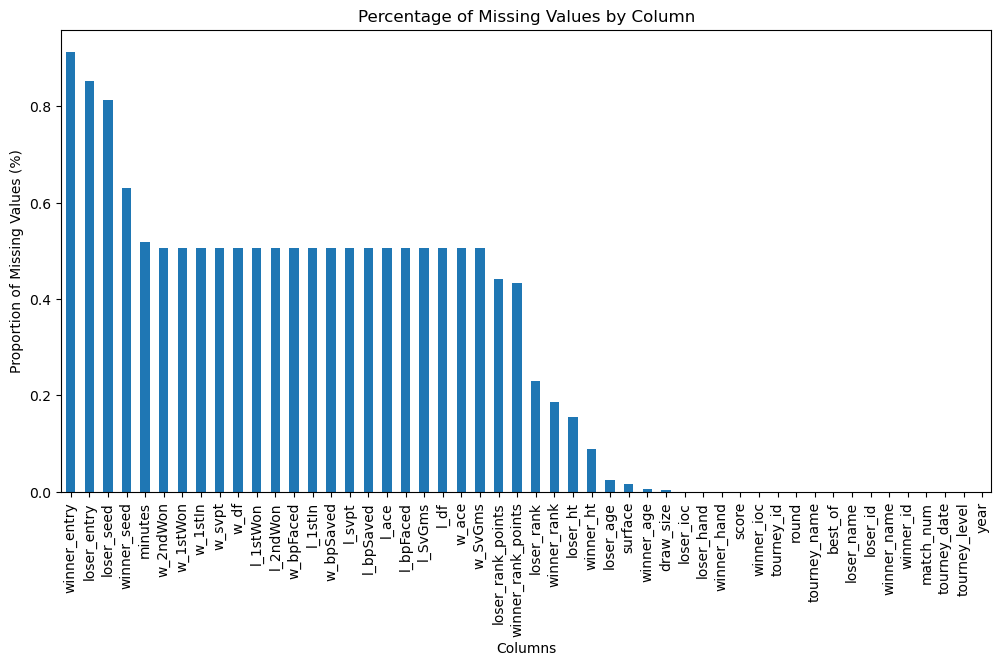

In [59]:
# Вычисляем процент пропущенных значений
percent_missing = df.isnull().mean().sort_values(ascending=False)

# Создаем тепловую карту отсортированных данных
percent_missing.plot(kind='bar', figsize=(12, 6))
plt.ylabel('Proportion of Missing Values (%)')
plt.xlabel('Columns')
plt.title('Percentage of Missing Values by Column')
plt.show()

В таких ячейках как: 'winner_entry', 'loser_entry', 'loser_seed' процент пропусков составляет более 60%. А значит они не будут статистически значимы и их можно удалить

In [60]:
# удаляем столбцы с пропусками более 60%
df = df.dropna(axis=1, thresh=(0.4 * df.shape[0]))


## Задание 1

### a) Если ранг игрока выше более, чем на 20 позиций, то в среднем он будет выигрывать с большей вероятностью. (Если хотите проверить статистически — формируйте выборку как отклонение от ожидаемого количества побед при случайном исходе);


У нас есть две гипотезы:

$H_0$: вероятность выигрыша не зависит от ранга игрока

$H_a$: если ранг игрока выше, чем ранг соперника более чем на 20 позиций, то в среднем вероятность выиграть у него больше



1) Сформируем 2 выборки: 

- игроки с рангом, отличающимся более чем на 20 позиций от противника,

- игроки с близким рангом к противнику (отличие менее 20 позиций)




In [55]:
df_rank_1 = df[['winner_id', 'loser_id', 'winner_rank', 'loser_rank']].dropna()
df_rank_1['higher_rank_win'] = abs((df_rank_1['winner_rank'] - df_rank_1['loser_rank'])) > 20

In [56]:
df_rank_1['higher_rank_win'].value_counts()

higher_rank_win
True     106767
False     37093
Name: count, dtype: int64

2) Для каждой игры в выборках посчитать ожидаемое количество побед при случайном исходе. Это можно сделать, умножив количество сыгранных игр на вероятность выигрыша 0,5 (при равных шансах для каждого игрока).

3) Посчитать фактическое количество побед для каждого игрока в выборках.

4) Вычислить отклонение фактического количества побед от ожидаемого для каждого игрока.

In [6]:
def player_metrics(df_rank_1):
    """
    Функция для расчета:
    - ожидаемого количества побед при случайном исходе, 
    - фактического количества побед для каждого игрока,
    - отклонения фактического количества побед от ожидадаемого для каждого игрока.

    """
    wins_count = df_rank_1['winner_id'].value_counts().astype(int).rename('wins')
    losses_count = df_rank_1['loser_id'].value_counts().astype(int).rename('losses')
    total_games = wins_count.add(losses_count, fill_value=0).astype(int).rename('total')
    player_performance_df = pd.concat([wins_count, losses_count, total_games], axis=1).reset_index().rename(columns={'index': 'player_id'})
    player_performance_df['expected_wins'] = player_performance_df['total'] * 0.5
    player_performance_df['deviation'] = player_performance_df['wins'] - player_performance_df['expected_wins']
    return player_performance_df.sort_values(by='total', ascending=False)

In [58]:
more20 = player_metrics(df_rank_1[df_rank_1['higher_rank_win'] == True])
less20 = player_metrics(df_rank_1[df_rank_1['higher_rank_win'] == False])

In [59]:
more20.head()

,player_id,wins,losses,total,expected_wins,deviation
0,103819,821.0,103.0,924,462.0,359.0
1,104745,694.0,88.0,782,391.0,303.0
4,101736,614.0,132.0,746,373.0,241.0
2,104925,661.0,73.0,734,367.0,294.0
3,100656,626.0,86.0,712,356.0,270.0


In [60]:
less20.head()

,player_id,wins,losses,total,expected_wins,deviation
0,103819,441.0,177.0,618,309.0,132.0
1,104925,437.0,141.0,578,289.0,148.0
2,104745,385.0,139.0,524,262.0,123.0
3,100656,325.0,145.0,470,235.0,90.0
4,100284,277.0,138.0,415,207.5,69.5


5. Рассчитать среднее отклонение для каждой выборки.

6. Сравнить средние отклонения между выборками.

In [71]:
# Рассчитаем среднее отклонение для каждой выборки
mean_dev_more20 = more20.deviation.dropna().abs().mean()
mean_dev_less20 = less20.deviation.dropna().abs().mean()

print(f'Cреднее отклонение для выборки more20: {round(mean_dev_more20, 2)}')
print(f'Cреднее отклонение для выборки less20: {round(mean_dev_less20, 2)}')


Cреднее отклонение для выборки more20: 9.94
Cреднее отклонение для выборки less20: 3.41


В первой выборке (ранг выше более чем на 20 позиций) среднее отклонение значительно выше, чем во второй выборке, то это подтверждает гипотезу о большей вероятности выигрыша у игроков с более высоким рангом.

## Проверка выборок на нормальность

1. Подсчет основных характеристик выборки:

- выборочное среднее;

- медиана;

- коэффицициенты ассиметрии;

- коэффициенты эксцесса.

In [61]:
def df_characteristics(df1, df2):
    """
    Функция для вывода основных характеристик выборок
    """
    print('Основные характеристики выборки df1')
    print(f'Выборочное среднее: {round(df1.mean(), 2)};\nВыборочная медиана: {df1.median()};\nВыборочная мода: {df1.mode()[0]};\nВыборочное среднеквадратичное отклонение: {round(df1.std(), 2)};\nВыборочный коэффициент асиметрии: {round(df1.skew(), 2)};\nВыборочный эксцесс: {round(df1.kurtosis(), 2)}')
    print()
    print('Основыне харктеристики выборки df2')
    print(f'Выборочное среднее: {round(df2.mean(), 2)};\nВыборочная медиана: {df2.median()};\nВыборочная мода: {df2.mode()[0]};\nВыборочное среднеквадратичное отклонение: {round(df2.std(), 2)};\nВыборочный коэффициент асиметрии: {round(df2.skew(), 2)};\nВыборочный эксцесс: {round(df2.kurtosis(), 2)}')

In [74]:
df_characteristics(more20.deviation.dropna(), less20.deviation.dropna())

Основные характеристики выборки df1
Выборочное среднее: 0.42;
Выборочная медиана: -2.5;
Выборочная мода: 0.0;
Выборочное среднеквадратичное отклонение: 25.24;
Выборочный коэффициент асиметрии: 6.38;
Выборочный эксцесс: 57.23

Основыне харктеристики выборки df2
Выборочное среднее: 0.15;
Выборочная медиана: -0.5;
Выборочная мода: 0.5;
Выборочное среднеквадратичное отклонение: 9.32;
Выборочный коэффициент асиметрии: 8.76;
Выборочный эксцесс: 109.19


При нормальном распределении, которое симметрично, значение медианы и выборочного среднего будут одинаковы, значение эксцесса равно 3, а асимметрии равно 0.

Как мы видим, значения выборочного среднего и медина различны, а значит распределения что в одном, что во втором случае несимметричны. Выборочный коэффициенты асимметрии больше 0, а значит распределения имеют перекос влево (скорее всего выбросы). А значение эксцесса больше 3, что указывает на островершинное распределение.

2. Графическое представление:

 - гистрограмма

 - QQ-plot

In [62]:
def graphic_image_df(df1, df2):
    """
    Функция для построения графиков распределения:
    - гистрограмма
    - QQ-plot
    """
    ffig, axs = plt.subplots(2, 2, figsize=(10, 15))
    plt.subplots_adjust(hspace=0.5)
    datasets = [df1, df2]
    titles = ['df1', 'df2']

    # Создание гистограмм и QQ-plot в цикле
    for idx, dataset in enumerate(datasets):
        sns.histplot(dataset, kde=True, ax=axs[0, idx])
        axs[0, idx].set_title(f'Гистограмма для {titles[idx]}')
        
        # Создание QQ-plot
        probplot(dataset, plot=axs[1, idx])
        axs[1, idx].set_title(f'График QQ для {titles[idx]}')
        
        # Добавление линии на QQ-plot
        (osm, osr), (slope, intercept, r) = probplot(dataset)
        line_x = np.array([osm[0], osm[-1]])
        line_y = intercept + slope * line_x
        axs[1, idx].plot(line_x, line_y, 'r', lw=2)

    plt.show()

    

/home/ruugi/miniconda3/envs/ds/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ruugi/miniconda3/envs/ds/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


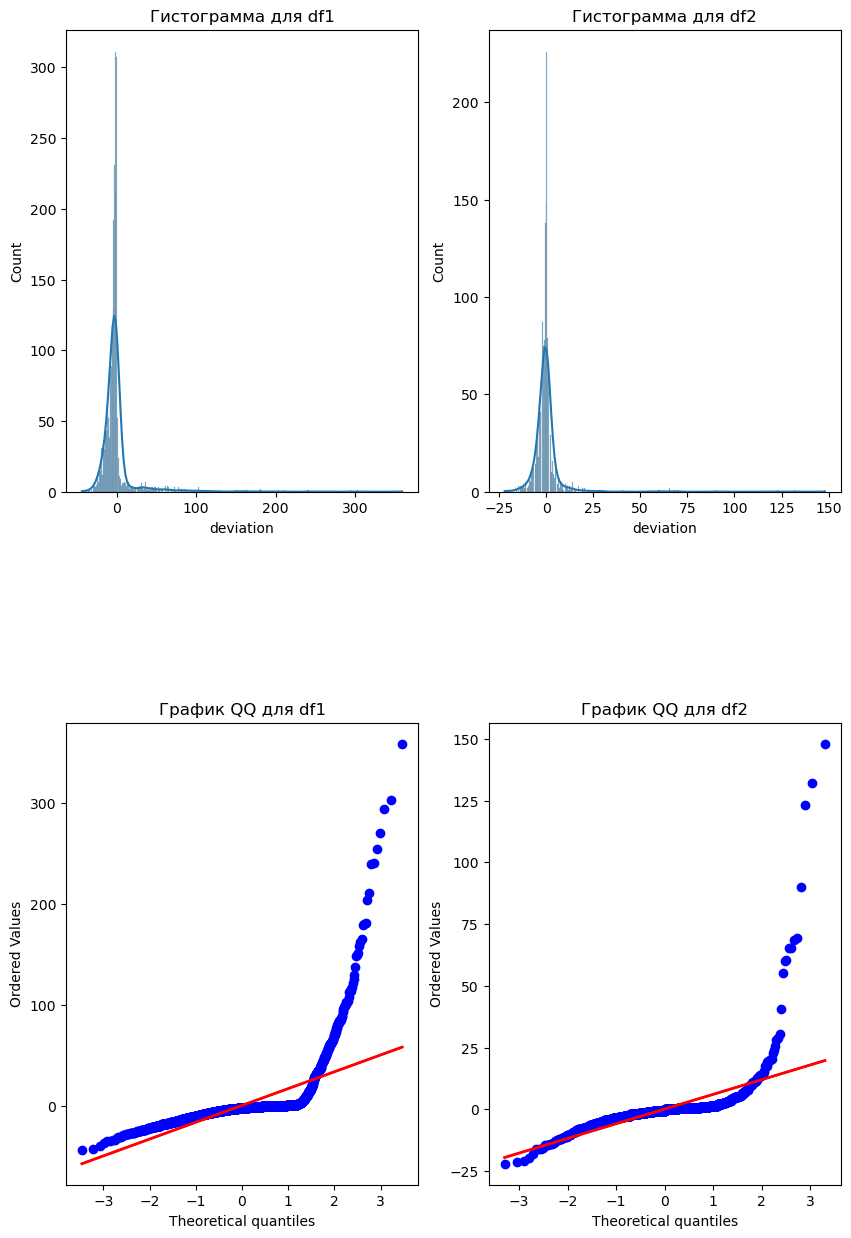

In [75]:
graphic_image_df(more20.deviation.dropna(), less20.deviation.dropna())

Графически мы также видим, что данные сильно смещенны влево, а на QQ имеются хвосты и разреженные значения на концах.

3. Статистические тесты:
- тест Шапиро-Уилка

- тест Д'Агостино

In [63]:
def shapiro_test(df1, df2, alpha=0.05):
    """
    Функция для проверки нормальности распределения в двух выборках с помощью критерия Шапиро-Уилка
    """
    H0 = 'Распределения в обеих группах нормальные'
    H1 = 'Распределение в одной или обеих группах отлично от нормального'

    # вычисляем результат теста Шапиро-Уилка для выборок
    shapiro_result_a = shapiro(df1)
    shapiro_result_b = shapiro(df2)
    print(f'alpha: {alpha}')
    print('p-value группы А', round(shapiro_result_a.pvalue, 3))
    print('p-value группы B', round(shapiro_result_b.pvalue, 3))
    # сравниваем полученное p-value с уровнем значимости
    if shapiro_result_a.pvalue < alpha or shapiro_result_b.pvalue < alpha:
        print("Отвергаем нулевую гипотезу. {}".format(H0))
        print("Альтернативная гипотеза. H1: {}".format(H1))
    else:
        print("Принимаем нулевую гипотезу. {}".format(H0))

In [76]:
shapiro_test(more20['deviation'].dropna(), less20['deviation'].dropna())

alpha: 0.05
p-value группы А 0.0
p-value группы B 0.0
Отвергаем нулевую гипотезу. Распределения в обеих группах нормальные
Альтернативная гипотеза. H1: Распределение в одной или обеих группах отлично от нормального


- Тест Д'Агостино

In [64]:
def test_normality(data, alpha=0.05):
    """
    Функция для проверки нормальности распределения данных
    """
    _, p = normaltest(data)
    print('p=%.3f' % (p))
    
    if p > alpha:
        print('Данные распределены нормально')
    else:
        print('Данные не распределены нормально')

In [63]:
test_normality(more20.deviation.dropna())
test_normality(less20.deviation.dropna())

p=0.000
Данные не распределены нормально
p=0.000
Данные не распределены нормально




Данные распределены  <u>не нормально</u>

## Выбор статистического теста

Тест Манна-Уитни - [документация](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mannwhitneyu.html)

<u>Обоснование выбора теста:</u>

1) *Непараметрический метод.*  Как уже было выше доказано, выборки не подчиняются нормальному распределению.

2) *Устойчивость к выбросам.* Из гистограмм мы увидели, что наши выборки сильно смещены влево из-за выбросов.

3) *Сравнение медиан.* Необходимо узнать, есть ли статистическая значимость в медианах отклонений между двумя независимыми выборками.

4) *Различные размеры выборок.* Тест Манна-Уитни можно применять, даже если размеры выборок сильно отличается, как в нашем случае 

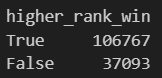

Необходимо провести односторонний тест и в качестве параметра alternative выбрать greater, так как мы предпологаем, что медиана more20 больше, чем мединаа less20


In [67]:
# Инициализация выборок
df1 = more20.deviation.dropna()
df2 = less20.deviation.dropna()

# Формулировка гипотез
H0 = 'Медиана more20 не больше медианы для less20'
H1 = 'Медиана more20 больше медианы less20'

# Проведение одностороннего U-теста Манна-Уитни
stat, p = mannwhitneyu(df1, df2, alternative='greater')

# Вывод результатов
print(f'U-статистика: {stat}')
print(f'p-значение: {p}')

# Уровень значимости
alpha = 0.05

# Сравнение p-значения с уровнем значимости
if p < alpha:
    print(f'Отвергаем нулевую гипотезу: {H0} при a = {alpha}.')
    print(f'Принимаем альтернативную гипотезу: {H1} при a = {alpha}.')
else:
    print(f'Не отвергаем нулевую гипотезу: {H0} при a = {alpha}.')

U-статистика: 1211034.0
p-значение: 1.0
Не отвергаем нулевую гипотезу: Медиана more20 не больше медианы для less20 при a = 0.05.


### б)  Если ранг игрока находится в окне +-5 позиций, то вероятность победы будет значительно отличаться от гипотезы из предыдущего случая. Для проверки статистической значимости выборку можно сделать как среднее по годам (например, с 1980 по 2022г.). Подумайте, как правильно сформировать репрезентативную выборку.

В данном случае для проверки статистической значимости гипотезы о том, что вероятность победы игроков с рангами, отличающимися не более чем на 5 позиций, будет значительно отличаться от предыдущего случая (ранги различаются более чем на 20 позиций), то есть надо сделать выборку в случае если ранг отличается на 5 позиций. Нужно сравнить среднее количество побед между двумя группами.

Формирование выборки:

In [11]:
df_1_b = df[['year', 'winner_id', 'loser_id', 'winner_rank', 'loser_rank']].dropna()

df_1_b['rank_winndows'] = abs((df_1_b['winner_rank'] - df_1_b['loser_rank'])) <= 5

In [12]:
df_1_b['rank_winndows'].value_counts()

rank_winndows
False    133840
True      10020
Name: count, dtype: int64

In [13]:
df_1_b.head()

,year,winner_id,loser_id,winner_rank,loser_rank,rank_winndows
0,1999,102158,102863,4.0,115.0,False
1,1999,101792,101793,64.0,77.0,False
2,1999,102562,102776,75.0,59.0,False
3,1999,103720,103017,100.0,35.0,False
4,1999,101727,103324,27.0,81.0,False


In [14]:
# Фильтруем по годам
filtered_df = df_1_b.query('1984 <= year <= 2022')

In [30]:
# Вычисляем среднее количество побед 
average_wins = (filtered_df
                .groupby(['winner_id', 'year', 'rank_winndows'])
                .size()
                .groupby(['year', 'rank_winndows'])
                .mean()
                .reset_index(name='average_win_count'))

# Разделяем на две группы с помощью метода query
average_wins_in = average_wins.query('rank_winndows == True')
average_wins_out = average_wins.query('rank_winndows == False')

In [32]:
average_wins_in.head()

,year,rank_winndows,average_win_count
1,1984,True,1.873563
3,1985,True,1.966292
5,1986,True,2.144330
7,1987,True,1.938776
9,1988,True,1.803738


In [33]:
average_wins_out.head()

,year,rank_winndows,average_win_count
0,1984,False,9.740000
2,1985,False,10.194719
4,1986,False,9.925170
6,1987,False,10.261146
8,1988,False,9.845930


In [44]:
# Рассчитаем среднее отклонение для каждой выборки
mean_dev_in = average_wins_in.average_win_count.dropna().abs().mean()
mean_dev_out = average_wins_out.average_win_count.dropna().abs().mean()

print(f'Cреднее отклонение для выборки in: {round(mean_dev_in, 2)}')
print(f'Cреднее отклонение для выборки out: {round(mean_dev_out, 2)}')


Cреднее отклонение для выборки in: 2.3
Cреднее отклонение для выборки out: 10.39


## Проверяем нормальность распределений:

Используем созданную выше функцию 'df_characteristics' для подсчета основных характеристик выборок

In [38]:
df_characteristics(average_wins_in.average_win_count, average_wins_out.average_win_count)

Основные характеристики выборки df1
Выборочное среднее: 2.3;
Выборочная медиана: 2.3222222222222224;
Выборочная мода: 1.7777777777777777;
Выборочное среднеквадратичное отклонение: 0.24;
Выборочный коэффициент асиметрии: -0.27;
Выборочный эксцесс: 0.31

Основыне харктеристики выборки df2
Выборочное среднее: 10.39;
Выборочная медиана: 10.25287356321839;
Выборочная мода: 6.512315270935961;
Выборочное среднеквадратичное отклонение: 0.9;
Выборочный коэффициент асиметрии: -1.77;
Выборочный эксцесс: 7.97


Используя, созданную выше функцию 'graphic_image_df' выводим графическое распределение выборок

/home/ruugi/miniconda3/envs/ds/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ruugi/miniconda3/envs/ds/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


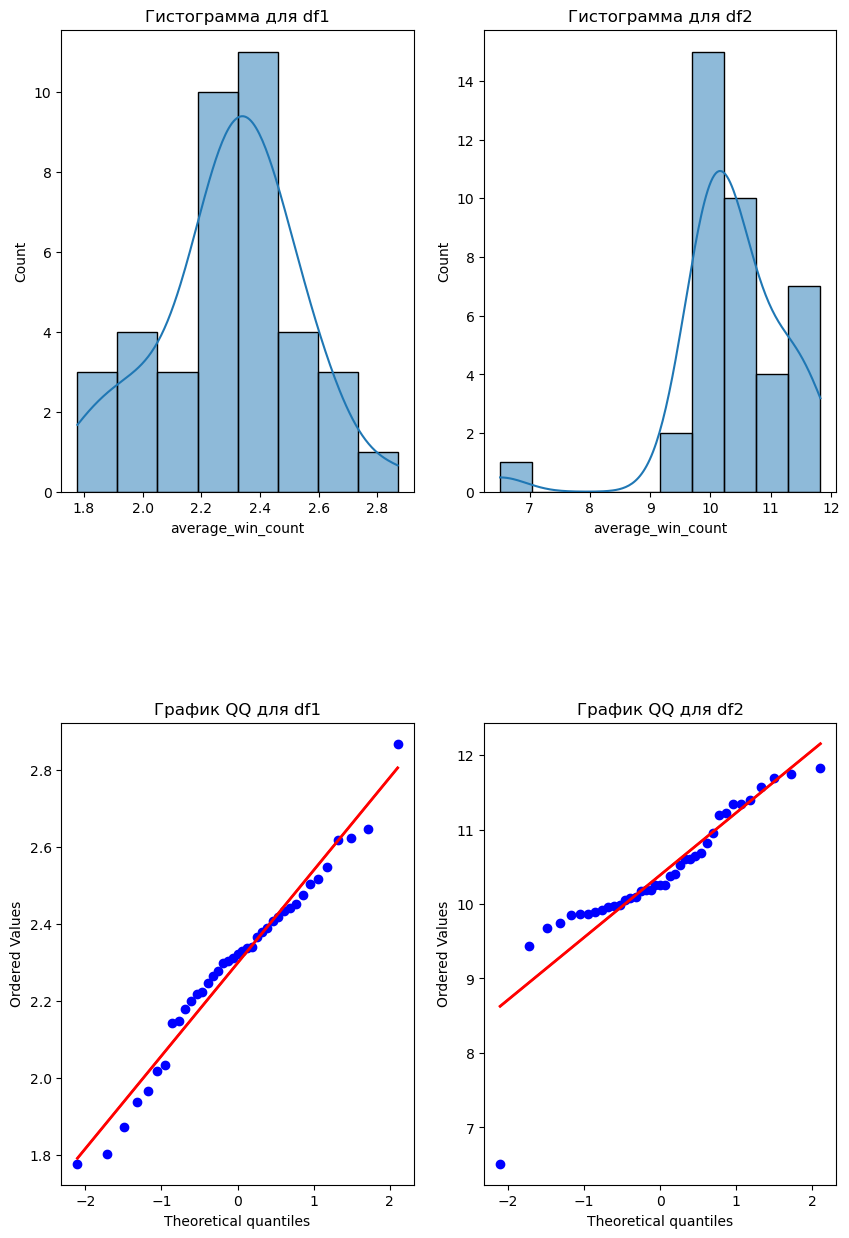

In [39]:
graphic_image_df(average_wins_in.average_win_count, average_wins_out.average_win_count)

Используем тест Шапиро и Д'Агостино

In [40]:
shapiro_test(average_wins_in.average_win_count, average_wins_out.average_win_count)

alpha: 0.05
p-value группы А 0.572
p-value группы B 0.0
Отвергаем нулевую гипотезу. Распределения в обеих группах нормальные
Альтернативная гипотеза. H1: Распределение в одной или обеих группах отлично от нормального


In [42]:
test_normality(average_wins_in.average_win_count.dropna())
test_normality(average_wins_out.average_win_count.dropna())

p=0.623
Данные распределены нормально
p=0.000
Данные не распределены нормально


Так как одна из выборок не имеет нормальное распределение, предпочтительным тестом будет непараметрический тест Манна-Уитни. В данном случае, в параметре 'alternative' выбираем 'less', так как среднее отклонение во второй выборке значительно больше. А значит есть предположение, что гипотеза о том, что если ранг игрока находится в окне $\pm$ 5 позиций, то вероятность победы будет значительно отличаться от гипотезы из предыдущего случая - не отличается

In [45]:
# Инициализация выборок
df1 = average_wins_in.average_win_count.dropna()
df2 = average_wins_out.average_win_count.dropna()

# Формулировка гипотез
H0 = 'Среднее количество побед игроков входящих в окно больше'
H1 = 'Среднее количество побед игроков не входящих в окно больше'

# Проведение одностороннего U-теста Манна-Уитни
stat, p = mannwhitneyu(df1, df2, alternative='less')

# Вывод результатов
print(f'U-статистика: {stat}')
print(f'p-значение: {p}')

# Уровень значимости
alpha = 0.05

# Сравнение p-значения с уровнем значимости
if p < alpha:
    print(f'Отвергаем нулевую гипотезу: {H0} при a = {alpha}.')
    print(f'Принимаем альтернативную гипотезу: {H1} при a = {alpha}.')
else:
    print(f'Не отвергаем нулевую гипотезу: {H0} при a = {alpha}.')

U-статистика: 0.0
p-значение: 1.5393187778399125e-14
Отвергаем нулевую гипотезу: Среднее количество побед игроков входящих в окно больше при a = 0.05.
Принимаем альтернативную гипотезу: Среднее количество побед игроков не входящих в окно больше при a = 0.05.


## Задача 2

Правда ли, что среднее количество сетов, которое необходимо любому игроку для победы в матче, сокращается со временем? Разбейте данные на две группы — с 1980 до 2001 гг. и 2002-2022 гг. Как изменилось среднее количество сетов, которое победитель затратил на игру? Является ли разница средних этих двух выборок статистически значимой? Выбор статистического теста обоснуйте.

Формируем выборку:

In [21]:
df_2 = df[['year', 'winner_id', 'score']].dropna()

In [12]:
df_2.shape

(191911, 3)

In [13]:
df_2.tail()

,year,winner_id,score
191915,1988,101222,4-6 6-1 4-6 6-4 9-7
191916,1988,100800,6-2 6-3 6-0
191917,1988,101382,6-2 6-2 6-3
191918,1988,101382,6-2 6-2 6-2
191919,1988,100800,6-3 6-0


In [22]:
# Функция для подсчета количества сетов
def count_sets_with_scores(score):
    sets = score.split()  
    return len(sets) - 1

df_2['count_sets'] = df_2['score'].apply(count_sets_with_scores)

In [23]:
# Разделение по годам
df_1980_2001 = df_2.query('1980 <= year <= 2001')
df_2002_2022 = df_2.query('2002 <= year <= 2022')

In [32]:
df_2002_2022.count_sets.value_counts()

count_sets
1    30539
2    24074
3     4504
4     2674
0      330
5       38
Name: count, dtype: int64

In [34]:
df_2002_2022[df_2002_2022['count_sets'] == 0]

,year,winner_id,score,count_sets
3582,2010,103997,W/O,0
3756,2010,104925,W/O,0
3819,2010,103656,W/O,0
3932,2010,103794,W/O,0
4169,2010,105064,W/O,0
...,...,...,...,...
187086,2020,105216,W/O,0
187101,2020,105155,W/O,0
187179,2020,206173,W/O,0
187983,2020,105227,W/O,0


In [35]:
df_1980_2001.shape

(80064, 4)

In [36]:
df_2002_2022.shape

(62159, 4)

In [24]:
# Среднее количество сетов
mean_1980_2001 = df_1980_2001.count_sets.mean()
mean_2002_2022 = df_2002_2022.count_sets.mean()

print(f'Среднее количество сетов в 1980-2001: {round(mean_1980_2001, 2)}')
print(f'Среднее количество сетов в 2002-2022: {round(mean_2002_2022, 2)}')

Среднее количество сетов в 1980-2001: 1.62
Среднее количество сетов в 2002-2022: 1.66


## Проверка нормальности распределения выборок

In [19]:
df_characteristics(df_1980_2001.count_sets, df_2002_2022.count_sets)

Основные характеристики выборки df1
Выборочное среднее: 2.62;
Выборочная медиана: 2.0;
Выборочная мода: 2;
Выборочное среднеквадратичное отклонение: 0.78;
Выборочный коэффициент асиметрии: 1.26;
Выборочный эксцесс: 1.44

Основыне харктеристики выборки df2
Выборочное среднее: 2.66;
Выборочная медиана: 3.0;
Выборочная мода: 2;
Выборочное среднеквадратичное отклонение: 0.8;
Выборочный коэффициент асиметрии: 1.16;
Выборочный эксцесс: 1.18


/home/ruugi/miniconda3/envs/ds/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ruugi/miniconda3/envs/ds/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


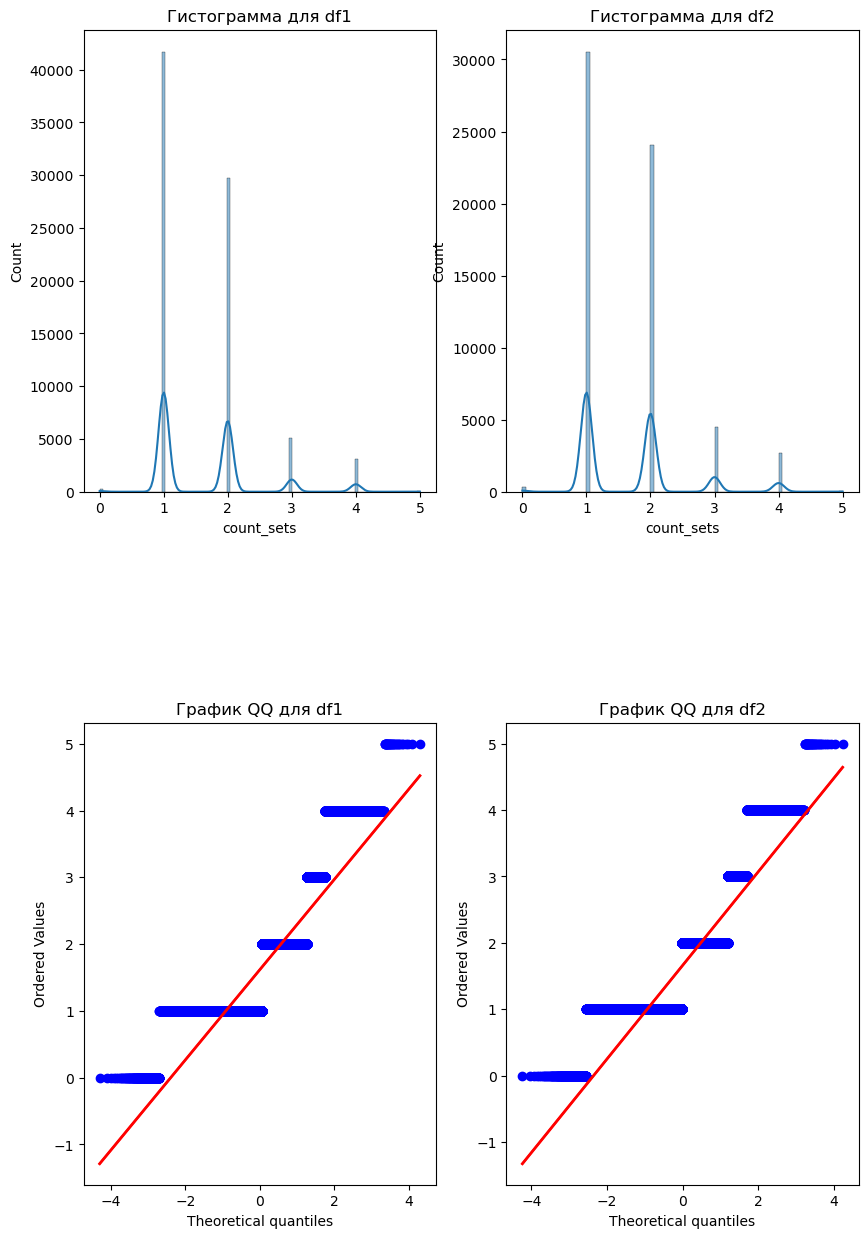

In [40]:
graphic_image_df(df_1980_2001.count_sets, df_2002_2022.count_sets)

In [59]:
shapiro_test(df_1980_2001.count_sets, df_2002_2022.count_sets)

alpha: 0.05
p-value группы А 0.0
p-value группы B 0.0
Отвергаем нулевую гипотезу. Распределения в обеих группах нормальные
Альтернативная гипотеза. H1: Распределение в одной или обеих группах отлично от нормального


/home/ruugi/miniconda3/envs/ds/lib/python3.12/site-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [60]:
test_normality(df_1980_2001.count_sets.dropna())
test_normality(df_2002_2022.count_sets.dropna())

p=0.000
Данные не распределены нормально
p=0.000
Данные не распределены нормально


Выше сделанные расчеты указывают: 

- расчитанные характеристики указывают на то, что выборки нормальные, потому что выборочное среднее и медиана у обоих выборок очень близки, выборочный коэффициент близок к 0, а коэффициент эксцесса не больше 3. 

- Гистограмма распределения имеет много пиков и QQ-plot показыает горизонтальные линейные участки - это указывает на ненормальность распределения

- Тесты Шапиро и Д'Агостино указывают на не нормальное распределение.

Исходя из вышесказанного примем, что выборки не имеют нормального распределения, поэтому будет использовать снова тест Манна-Уитни, потому что хотим сравнить 2 независимые выборки

In [25]:
# Инициализация выборок
df1 = df_1980_2001.count_sets.dropna()
df2 = df_2002_2022.count_sets.dropna()

# Формулировка гипотез
H0 = 'Среднее количество сетов за период с 1980-2001 меньше или равно среднему количеству сетов за период 2002-2022'
H1 = 'Cреднее количество сетов за период с 2002-2022 меньше среднего за период 1982-2001'

# Проведение одностороннего U-теста Манна-Уитни
stat, p = mannwhitneyu(df1, df2, alternative='less')

# Вывод результатов
print(f'U-статистика: {stat}')
print(f'p-значение: {p}')

# Уровень значимости
alpha = 0.05

# Сравнение p-значения с уровнем значимости
if p < alpha:
    print(f'Отвергаем нулевую гипотезу: {H0} при a = {alpha}.')
    print(f'Принимаем альтернативную гипотезу: {H1} при a = {alpha}.')
else:
    print(f'Не отвергаем нулевую гипотезу: {H0} при a = {alpha}.')

U-статистика: 2414301469.0
p-значение: 6.005374104386554e-27
Отвергаем нулевую гипотезу: Среднее количество сетов за период с 1980-2001 меньше или равно среднему количеству сетов за период 2002-2022 при a = 0.05.
Принимаем альтернативную гипотезу: Cреднее количество сетов за период с 2002-2022 меньше среднего за период 1982-2001 при a = 0.05.


## Задание 3

У вас появились сомнения — не является ли результат, который вы посчитали на предыдущем шаге, некорректным. Кажется, что на это мог повлиять формат самого матча — best of 3 или best of 5. Оставьте только матчи best of 5 (колонка best_of) и определите — является ли разница среднего количества сетов, которое сыграл победитель, значимой для выборок матчей по 1980 до 2001 гг. и 2002-2022 гг. Выбор статистического теста обоснуйте.

Чтобы сформировать датасет надо:

- Фильтрация данных: Оставить только матчи, где значение в колонке best_of равно 5. Это можно сделать, создав новый фрейм данных, который содержит только строки, где df['best_of'] == 5.

- Разделение данных на две группы: Разделите данные на две группы в зависимости от года матча. Одна группа должна содержать матчи с 1980 по 2001 год, а другая с 2002 по 2022 год. Это можно сделать с помощью логического индексирования по столбцу с годами.

In [10]:
df_3 = df[['year', 'winner_id', 'score', 'best_of']].dropna()

df_3 = df_3[df_3['best_of'] == 5]

In [11]:
# Функция для подсчета количества сетов
def count_sets_with_scores(score):
    sets = score.split()  
    return len(sets) - 1

df_3['count_sets'] = df_3['score'].apply(count_sets_with_scores)

In [12]:
# Разделение по годам
df_1980_2001_best = df_3.query('1980 <= year <= 2001')
df_2002_2022_best = df_3.query('2002 <= year <= 2022')

In [13]:
# Среднее количество сетов
mean_1980_2001_best = df_1980_2001_best.count_sets.mean()
mean_2002_2022_best = df_2002_2022_best.count_sets.mean()

print(f'Среднее количество сетов в 1980-2001: {round(mean_1980_2001_best, 2)}')
print(f'Среднее количество сетов в 2002-2022: {round(mean_2002_2022_best, 2)}')

Среднее количество сетов в 1980-2001: 2.69
Среднее количество сетов в 2002-2022: 2.67


## Проверка нормальности распределения

In [14]:
df_characteristics(df_1980_2001_best.count_sets, df_2002_2022_best.count_sets)

Основные характеристики выборки df1
Выборочное среднее: 2.69;
Выборочная медиана: 3.0;
Выборочная мода: 2;
Выборочное среднеквадратичное отклонение: 0.8;
Выборочный коэффициент асиметрии: 0.48;
Выборочный эксцесс: -0.8

Основыне харктеристики выборки df2
Выборочное среднее: 2.67;
Выборочная медиана: 2.0;
Выборочная мода: 2;
Выборочное среднеквадратичное отклонение: 0.8;
Выборочный коэффициент асиметрии: 0.46;
Выборочный эксцесс: -0.6


/home/ruugi/miniconda3/envs/ds/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ruugi/miniconda3/envs/ds/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


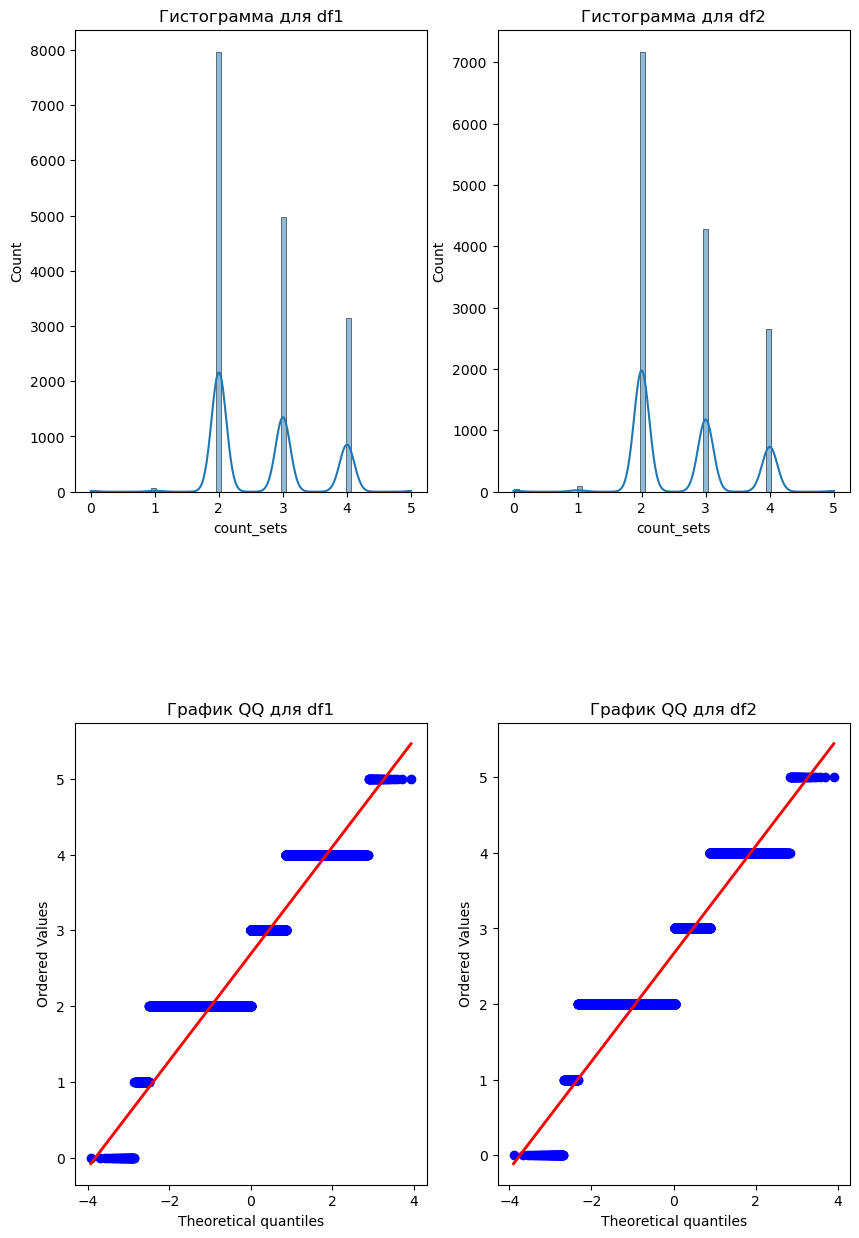

In [15]:
graphic_image_df(df_1980_2001_best.count_sets, df_2002_2022_best.count_sets)

In [16]:
shapiro_test(df_1980_2001_best.count_sets, df_2002_2022_best.count_sets)

alpha: 0.05
p-value группы А 0.0
p-value группы B 0.0
Отвергаем нулевую гипотезу. Распределения в обеих группах нормальные
Альтернативная гипотеза. H1: Распределение в одной или обеих группах отлично от нормального


/home/ruugi/miniconda3/envs/ds/lib/python3.12/site-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [17]:
test_normality(df_1980_2001_best.count_sets.dropna())
test_normality(df_2002_2022_best.count_sets.dropna())

p=0.000
Данные не распределены нормально
p=0.000
Данные не распределены нормально


Картина аналогичная задаче 2, поэтому снова возьмем тест Манна-Уитни

In [19]:
df1 = df_1980_2001_best.count_sets.dropna()
df2 = df_2002_2022_best.count_sets.dropna()

# Формулировка гипотез
H0 = 'Среднее количество сетов за период с 1980-2001 меньше или равно среднему количеству сетов за период 2002-2022'
H1 = 'Cреднее количество сетов за период с 2002-2022 меньше среднего за период 1982-2001'

# Проведение одностороннего U-теста Манна-Уитни
stat, p = mannwhitneyu(df1, df2, alternative='less')

# Вывод результатов
print(f'U-статистика: {stat}')
print(f'p-значение: {p}')

# Уровень значимости
alpha = 0.05

# Сравнение p-значения с уровнем значимости
if p < alpha:
    print(f'Отвергаем нулевую гипотезу: {H0} при a = {alpha}.')
    print(f'Принимаем альтернативную гипотезу: {H1} при a = {alpha}.')
else:
    print(f'Не отвергаем нулевую гипотезу: {H0} при a = {alpha}.')

U-статистика: 117641299.0
p-значение: 0.9972200388324056
Не отвергаем нулевую гипотезу: Среднее количество сетов за период с 1980-2001 меньше или равно среднему количеству сетов за период 2002-2022 при a = 0.05.


## Задача 4

Вы хотите изучить психологическую устойчивость профессиональных игроков в теннис. Одним из важных показателей такой устойчивости будет доля выигранных брейк-поинтов. Возьмите трех игроков (они необязательно должны играть в одно и то же время. Можете взять игроков, которые сильно отличаются по рангу, а можете взять примерно равных игроков), для каждого из них посчитайте долю выигранных брейк поинтов (колонки, заканчивающиеся на bpFaced и bpSaved) отдельно в победных и проигранных матчах за минимум 10 лет (можно больше, но годы должны идти подряд). Постройте box-plot’ы для этих статистик для каждого из игроков. Являются ли эти распределения по годам (по победным и по проигранным матчам) независимыми для каждого из игроков? Если сравнивать эту статистику между игроками — будет ли разница в средних для проигранных и выигранных матчей значимой попарно между всеми игроками? Выбор статистического теста обоснуйте.

- Выберите трех игроков с разным рангом или примерно равным уровнем игры.

- Для каждого игрока соберите данные о сыгранных матчах за период минимум 10 лет подряд. Данные должны включать количество брейк-поинтов, полученных игроком (bpFaced), и количество отыгранных брейк-поинтов (bpSaved) в каждом матче.

- Для каждого игрока разделите матчи на две группы: выигранные и проигранные.

- Посчитайте долю выигранных брейк-поинтов в каждой группе матчей за каждый год: Доля выигранных брейк-поинтов = bpSaved / bpFaced

In [65]:
df_4 = df[['year', 'winner_id', 'loser_id', 'w_bpSaved', 'w_bpFaced', 'l_bpSaved', 'l_bpFaced', 'winner_rank', 'loser_rank']].dropna()

In [55]:
df_4.head()

,year,winner_id,loser_id,w_bpSaved,w_bpFaced,l_bpSaved,l_bpFaced,winner_rank,loser_rank
0,1999,102158,102863,8.0,8.0,3.0,7.0,4.0,115.0
1,1999,101792,101793,1.0,1.0,5.0,8.0,64.0,77.0
2,1999,102562,102776,0.0,0.0,3.0,8.0,75.0,59.0
3,1999,103720,103017,1.0,1.0,8.0,10.0,100.0,35.0
4,1999,101727,103324,1.0,1.0,4.0,7.0,27.0,81.0


In [66]:
# Формируем выборку для 3 игроков
ids = list(df_4.winner_id.value_counts().head(3).index)
winners = df_4[df_4['winner_id'].isin(ids)]
aggregated_data = winners.groupby('winner_id').agg(winns_count=('winner_id', 'size'), winner_rank_max=('winner_rank', 'max'))


df_4 = df_4[(df_4['winner_id'].isin(ids)) | (df_4['loser_id'].isin(ids))]
df_4['game_result'] = df_4['winner_id'].apply(lambda x: 1 if x in ids else 0 if x in ids else None)


df_4['winned_bp'] = df_4.apply(lambda x: 
    round(x['w_bpSaved'] / x['w_bpFaced'] * 100, 1) if x['game_result'] == 1 and x['w_bpFaced'] != 0
    else round(x['l_bpSaved'] / x['l_bpFaced'] * 100, 1) if x['game_result'] == 0 and x['l_bpFaced'] != 0
    else None, axis=1)

In [67]:
df_4.game_result = df_4.game_result.fillna(0)

Выбираем период не менее 10 лет, в котором есть данные о всех 3 участниках

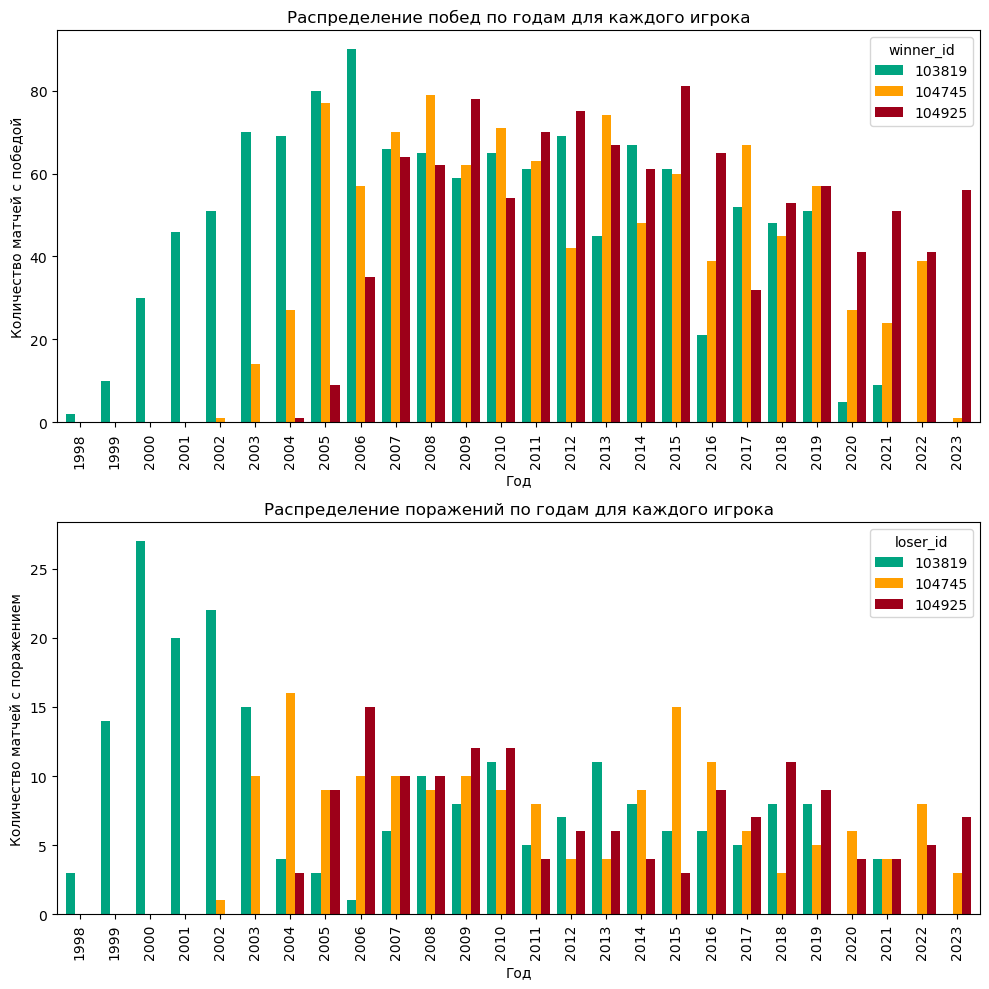

In [68]:
# Строим графики рапсределения побед и поражений игроков по годам
win_counts = df_4[df_4.game_result == 1].groupby(['year', 'winner_id']).size().unstack()
lose_counts = df_4[df_4.game_result == 0].groupby(['year', 'loser_id']).size().unstack()


fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))


win_plot = win_counts.plot(kind='bar', stacked=False, width=0.8, color=['#00A480', '#FF9F00', '#9D0019'], ax=axes[0])
win_plot.set_title('Распределение побед по годам для каждого игрока')
win_plot.set_xlabel('Год')
win_plot.set_ylabel('Количество матчей с победой')


lose_plot = lose_counts.plot(kind='bar', stacked=False, width=0.8, color=['#00A480', '#FF9F00', '#9D0019'], ax=axes[1])
lose_plot.set_title('Распределение поражений по годам для каждого игрока')
lose_plot.set_xlabel('Год')
lose_plot.set_ylabel('Количество матчей с поражением')


plt.tight_layout()
plt.show()

In [73]:
win_counts = win_counts.query('2007 <= year <= 2017')
lose_counts = lose_counts.query('2007 <= year <= 2017')

In [77]:
win_counts

winner_id,103819,104745,104925
year,,,
2007,66.0,70.0,64.0
2008,65.0,79.0,62.0
2009,59.0,62.0,78.0
2010,65.0,71.0,54.0
2011,61.0,63.0,70.0
2012,69.0,42.0,75.0
2013,45.0,74.0,67.0
2014,67.0,48.0,61.0
2015,61.0,60.0,81.0


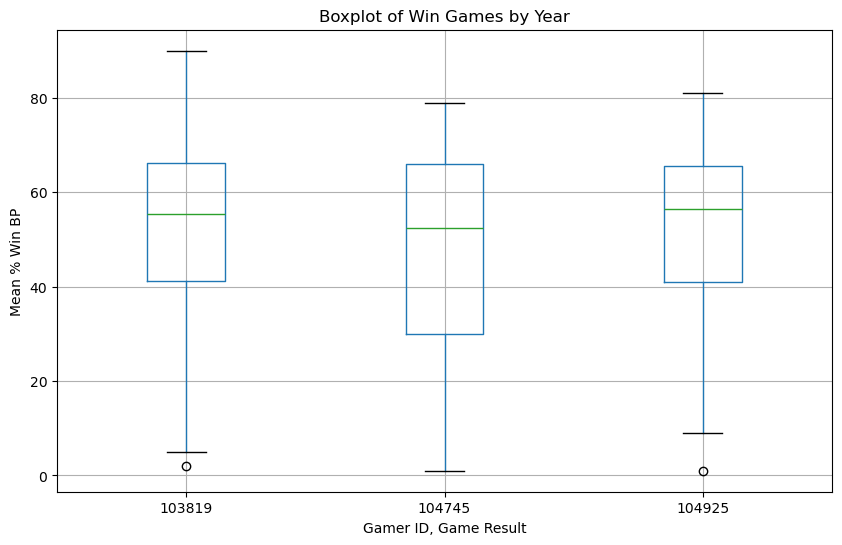

In [70]:
ax = win_counts.boxplot(figsize=(10, 6))
ax.set_title('Boxplot of Win Games by Year')
ax.set_xlabel('Gamer ID, Game Result')
ax.set_ylabel('Mean % Win BP')
plt.show()

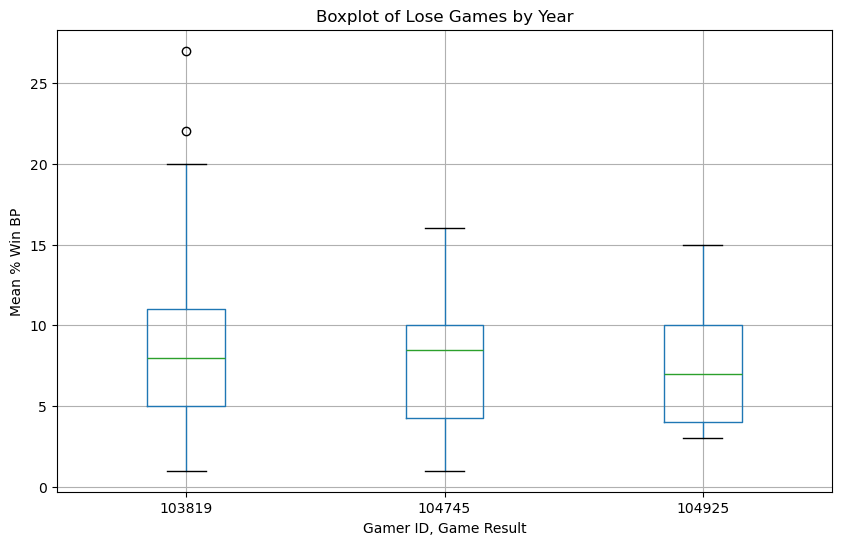

In [71]:
ax = lose_counts.boxplot(figsize=(10, 6))
ax.set_title('Boxplot of Lose Games by Year')
ax.set_xlabel('Gamer ID, Game Result')
ax.set_ylabel('Mean % Win BP')
plt.show()

Выбор статистического теста: 

Тест Краскела-Уоллиса  - [документация](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kruskal.html)

Это расширенный тест Манна-Уитни, когда надо сравнить более 2 групп.

In [88]:

# Объединим количество побед и поражений в один список для каждого игрока:
player_ids = [103819, 104745, 104925]
wins_losses = {player_id: pd.concat([win_counts[player_id], lose_counts[player_id]]) for player_id in player_ids}

# Проведем тест Краскела-Уоллиса
H0 = 'Принимаем нулевую гипотезу - медианы всех групп равны'
H1 = 'Отклоняем нулевую гипотезу - медианы одной или более групп различны'
kruskal_test_statistic, kruskal_p_value = kruskal(*wins_losses.values())

print(f'Kruskal-Wallis Test Statistic: {kruskal_test_statistic}')
print(f'Kruskal-Wallis Test P-Value: {kruskal_p_value}')
print(f'{H1}' if kruskal_p_value < 0.05 else f'{H0}')

# Тест Манна-Уитни для попарного сравнения
for i in range(len(player_ids)):
    for j in range(i + 1, len(player_ids)):
        # Получим данные побед и поражений для каждой пары игроков
        player_i_data = wins_losses[player_ids[i]]
        player_j_data = wins_losses[player_ids[j]]
        
        # Проведем тест Манна-Уитни
        mw_statistic, mw_p_value = mannwhitneyu(player_i_data, player_j_data, alternative='two-sided')
        
        print(f'Mann-Whitney Test between Player {player_ids[i]} and Player {player_ids[j]}:')
        print(f'Test Statistic: {mw_statistic}')
        print(f'P-Value: {mw_p_value}\n')
        print('Принимаем нулевую гипотезу - статистических различий не обнаружено' if mw_p_value > 0.05 else 'Отклоняем нулевую гипотезу - указывает на наличие статистических различий')

Kruskal-Wallis Test Statistic: 0.3784883665649159
Kruskal-Wallis Test P-Value: 0.827584399744928
Принимаем нулевую гипотезу - медианы всех групп равны
Mann-Whitney Test between Player 103819 and Player 104745:
Test Statistic: 217.0
P-Value: 0.5648121977531311

Принимаем нулевую гипотезу - статистических различий не обнаружено
Mann-Whitney Test between Player 103819 and Player 104925:
Test Statistic: 222.0
P-Value: 0.646703514384736

Принимаем нулевую гипотезу - статистических различий не обнаружено
Mann-Whitney Test between Player 104745 and Player 104925:
Test Statistic: 243.0
P-Value: 0.9906234290922383

Принимаем нулевую гипотезу - статистических различий не обнаружено


### Вывод:

Исходя из результатов обоих тестов, мы можем сделать вывод, что данные не показывают статистически значимых различий в количестве побед и поражений между рассматриваемыми игроками.

## Задание 5

У вас есть гипотеза, что доля выигранных брейк-поинтов связана с вероятностью победить в игре. Соберите статистику, где для каждого матча будет собран его исход (победа/поражение) и доля выигранных брейк-поинтов (не забудьте, что в матче два игрока). Разделите долю выигранных брейкпоинтов на группы выше/ниже медианы и, используя информацию о исходе матча, проверьте зависимость между количеством выигранных брейкпоинтов и результатом матча. Насколько сильна эта зависимость? Выбор статистического теста обоснуйте.

1. Создайте новый признак, который будет отражать долю выигранных брейк-поинтов для каждого игрока в матче. Для этого используйте следующую формулу:

Доля выигранных брейк-поинтов = (wbpSaved + lbpSaved) / (wbpFaced + lbpFaced)

2. После этого разделите выборку на две группы: матчи, где игроки выиграли брейк-поинты больше или равно медианы, и матчи, где они выиграли меньше медианы.

3. Составьте таблицу сопряжённости, где строки будут представлять долю выигранных брейк-поинтов (выше/ниже медианы), а столбцы — исход матча (победа/поражение).

In [94]:
# Сформируем датасет для задачи
task_05 = df[['year', 'winner_id', 'loser_id', 'w_bpSaved', 'w_bpFaced', 'l_bpSaved', 'l_bpFaced']].dropna()


task_05['bp_ratio_winner'] = round((task_05['w_bpSaved'] / task_05['w_bpFaced'] * 100).fillna(0), 1)
task_05['bp_ratio_loser'] = round((task_05['l_bpSaved'] / task_05['l_bpFaced'] * 100).fillna(0), 1)


winners = task_05[['year', 'winner_id', 'bp_ratio_winner']].rename(columns={'winner_id': 'id', 'bp_ratio_winner': 'bp_ratio'})
losers = task_05[['year', 'loser_id', 'bp_ratio_loser']].rename(columns={'loser_id': 'id', 'bp_ratio_loser': 'bp_ratio'})


winners['result'] = 1
losers['result'] = 0

task_05 = pd.concat([winners, losers], ignore_index=True)


losers_median = task_05.loc[task_05['result'] == 0, 'bp_ratio'].median()
winners_median = task_05.loc[task_05['result'] == 1, 'bp_ratio'].median()


conditions = [
    (task_05['bp_ratio'] >= winners_median) & (task_05['result'] == 1),
    (task_05['bp_ratio'] < winners_median) & (task_05['result'] == 1),
    (task_05['bp_ratio'] >= losers_median) & (task_05['result'] == 0),
    (task_05['bp_ratio'] < losers_median) & (task_05['result'] == 0)
]
choices = ['more median', 'less median', 'more median', 'less median']
task_05['breakpoints_level'] = np.select(conditions, choices, default='')

In [95]:
task_05.groupby('result')['breakpoints_level'].value_counts().unstack()

breakpoints_level,less median,more median
result,,
0,34803,60231
1,44026,51008


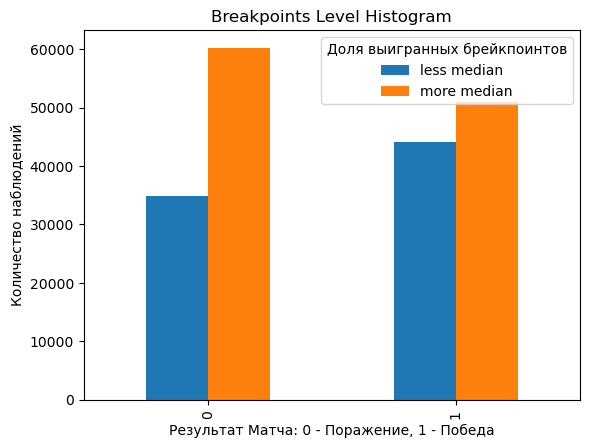

In [96]:
count_of_games = task_05.groupby('result')['breakpoints_level'].value_counts().unstack().plot(kind='bar')
count_of_games.set_title('Breakpoints Level Histogram')
plt.xlabel('Результат Матча: 0 - Поражение, 1 - Победа')
plt.ylabel('Количество наблюдений')
plt.legend(title='Доля выигранных брейкпоинтов')
plt.show()


In [97]:
count_of_games = task_05.groupby('result')['breakpoints_level'].value_counts().unstack()
count_of_games

breakpoints_level,less median,more median
result,,
0,34803,60231
1,44026,51008


### Выбор теста

Тест Уилкоксона - [документация](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.wilcoxon.html)

Это непарметрический тест для сравнения связанных выборок. Он сравнивает медианные значения между парами.

In [99]:
# Вычисление разностей между связанными выборками
differences = count_of_games['less median'] - count_of_games['more median']

# Выполнение теста
stat, p = wilcoxon(differences)

print('Статистика =', stat)
print('p-значение =', p)

Статистика = 0.0
p-значение = 0.5


### Вывод
В данном случае,  p-значение равно 0.5, это означает, что при уровне значимости 0.05 (или 5%), у нас нет статистически значимых доказательств для отвержения нулевой гипотезы о том, что медианы двух связанных выборок равны.

Таким образом, на основании этого результата, можно сделать вывод, что нет статистически значимой разницы между значениями "less median" и "more median" в датасете count_of_games.